# Single-user multidimensional modulation system over fading channels

**Author:** [Bruno Fontana da Silva](https://github.com/fontanads/)  
**Date:** 23/07/2020

This is a tutorial on how to simulate the error performance of single-user digital communication systems that adopt multidimensional modulations.

In [1]:
from IPython.display import clear_output
from time import time

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn

In [4]:
from su_mdm_utils import source_bits, bin2int_mapping, \
                         get_codebook, symbol_to_codeword_map, \
                         iid_rayleigh_channel, ML_detection, \
                         get_codebook_figures_of_merit, plot_multidimensional_modulation

In [5]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
# Valores padronizados para tamanho de fontes em gráficos
FOOTNOTE_SIZE = 11
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

# Método para configurar as fontes de um gráfico com base nos valores padronizados 
def set_fontsizes_in_plot():
    plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
set_fontsizes_in_plot()

## Explaining the building blocks of the system

Initially, consider the building blocks for the system simulation.  
Several functions have been implemented in the helper file ``su_mdm_utils.py``.  <br>
Use ``print(<FunctionName>.__doc__)`` or ``help(<FunctionName>)`` for more details on its implementation. 

In [8]:
# example on accessing the helper functions' documentation:
print(source_bits.__doc__)

Generates a bit stream of length k bits.
    
    Inputs:
        k: the desired length of the output bitstream
    
    Outputs:
        b: a row vector with k randomly generated bits
    


### Transmitter

We need to set a few parameters for the system.  
The transmitter will map $p$ packets of $k$ bits each to $p$ equivalent symbols of a mutildimensional modulation $\mathcal{C}\subset \mathbb{R}^N$, also known as a codebook. The codebook has cardinality $\left| \mathcal{C} \right| = M = 2^k$.  
Thus, a total of $p \times N$ orthogonal resources will be used. 

In [9]:
num_packets     = 10
bits_per_packet = 2
mod_size        = 2**bits_per_packet
n_dims = 3
SE = np.log2(mod_size)

The message being transmitted is a bit stream $\mathbf{b} \in \mathbb{F}_2^{kp}$.

In [10]:
b = source_bits(k=num_packets*bits_per_packet)
b.shape, b

((1, 20),
 array([[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]]))

Each packet of $k$ bits of $\mathbf{b}$ is mapped to an integer number in the finite field $\mathbb{Z}_M$.  
This mapping is defined as $\mathbf{s}= \mu \left( \mathbf{b} \right)$, where $\mathbf{s}\in \mathbb{Z}_M^p$.

In [11]:
s = bin2int_mapping(b,mod_size)
s.shape, s

((1, 10), array([[1, 0, 1, 0, 1, 0, 0, 2, 3, 2]]))

Next, a second mapping function $\lambda:\mathbb{Z}_M\to \mathcal{C}$ will encode each integer in a codeword from the codebook.  
To load the codebook $\mathbf{C}$, we use the following function.

In [12]:
codebook = get_codebook(path=None, M=mod_size, N=n_dims)
E = np.trace(codebook.T@codebook)
codebook.shape, E, codebook

((4, 3),
 4.0,
 array([[-0.77459667, -0.77459667, -0.77459667],
        [-0.25819889, -0.25819889, -0.25819889],
        [ 0.25819889,  0.25819889,  0.25819889],
        [ 0.77459667,  0.77459667,  0.77459667]]))

The codewords $\mathbf{c}^{(1)}, \ldots, \mathbf{c}^{(p)}$, where $\mathbf{c}^{(i)}=\lambda\left( s_i \right)$, are obtainted with the following mapping function:

In [13]:
codewords = symbol_to_codeword_map(s, codebook)
codewords.shape, codewords

((10, 3),
 array([[-0.25819889, -0.25819889, -0.25819889],
        [-0.77459667, -0.77459667, -0.77459667],
        [-0.25819889, -0.25819889, -0.25819889],
        [-0.77459667, -0.77459667, -0.77459667],
        [-0.25819889, -0.25819889, -0.25819889],
        [-0.77459667, -0.77459667, -0.77459667],
        [-0.77459667, -0.77459667, -0.77459667],
        [ 0.25819889,  0.25819889,  0.25819889],
        [ 0.77459667,  0.77459667,  0.77459667],
        [ 0.25819889,  0.25819889,  0.25819889]]))

which is currently just using the integers to index the corresponding row of the codebook and select its codeword.

### Channel and Received Signal

The channel between transmitter and receiver is subject to fading effects $h_n \sim \mathcal{N}\left(1/2, 0\right)$ in each orthogonal resource $n=1,\ldots,N$.  
The channel vector $\mathbf{h} = \begin{bmatrix}h_1, \ldots, h_N \end{bmatrix} \in \mathbb{R}^N$ is constant during the transmission of all $p$ codewords (block-fading).  
Thus, the received signal is writen as  
$\mathbf{y}^{(i)} = \text{diag}\left( \mathbf{h} \right) \mathbf{c}^{(i)} + \mathbf{z}^{(i)}$,  
where $\mathbf{z}^{(i)}$ is the additive noise vector whose entries are i.i.d. random variables distributed as $z_n^{(i)} \sim \mathcal{N}\left(0, \dfrac{\sigma^2}{2}\right)$   

In [14]:
# the parameter N0 corresponds to \sigma^2 in the previous equation
y, h = iid_rayleigh_channel(X=codewords, N0=1, fading=True, awgn=True)


In [15]:
print(y.shape, h.shape)
y, h

(10, 3) (1, 3)


(array([[-0.24360676,  0.0720357 , -1.26828533],
        [-0.96255939, -0.6947697 , -0.46235543],
        [ 0.30792032, -0.74112744, -0.91404142],
        [ 1.29351189, -0.45682033,  0.30157398],
        [-0.9217352 , -0.48399417,  0.16304222],
        [-0.55673365, -0.03151376, -0.17089137],
        [ 0.05088308, -0.7226432 ,  1.56358279],
        [-0.09525788, -0.64885711,  0.49701898],
        [-1.12040854,  0.44486124, -1.63952036],
        [-1.02488327,  0.23825937,  0.43756662]]),
 array([[-0.33196852,  0.38364789, -0.32768579]]))

### Detection

At the receiver, the estimated symbols $\hat{s}_i$ are obtained using maximum-likelihood detection:  
$\hat{s}_i = \min\limits_{s} \left| \mathbf{y}^{(i)} - \text{diag}\left(\mathbf{h}\right) \lambda\left( s\right) \right|^2 $,  
that is, the symbol corresponding to the codeword that minimizes the minimum euclidean-distance between the received vector and the faded candidates from the codebook.

In [16]:
ML_detection(y, h*codebook)

array([3, 3, 1, 0, 2, 3, 0, 0, 3, 3], dtype=int64)

## Monte Carlo Simulation

Now, a Monte Carlo simulation is designed to evaluate the average symbol error rate (SER) over the channel realizations for several signal-to-noise ratios (SNR). Initially, the simulation parameters are chosen.  

Among this parameters, ``min_sym_errors`` is the minimum number of symbol errors to be counted for each SeR $\times$ SNR point.  
Also, $P_e$ is the target error probability. If a simulation point achieves a SER lower than $P_e$, the simulation is interrupted.  

Finally, the transmit power $P$ is set to be equal to $N$, and we then define:  
$\dfrac{E_b}{N_0} = \dfrac{\text{SNR}}{k} = \dfrac{P}{\sigma^2 k}$

In [17]:
num_packets     = 50
bits_per_packet = 4
mod_size        = 2**bits_per_packet
n_dims          = 8
Psqrt           = np.sqrt(n_dims)

EbN0dB          = np.arange(0,31,1,dtype=np.float64)
LDS_Codebook    = Psqrt*get_codebook(path=None, M=mod_size, N=n_dims, LDS=True)

min_sym_errors  = 1000
Pe_min          = 1e-5
max_iters       = int((min_sym_errors/num_packets)/Pe_min)

print_iters     = 10000

The first codebook we are testing is a repetition code, that we name "low-density spreading" (LDS) due to its multiuser counterpart.  
A set of $M$ PAM projections will be repeated over $N$ dimensions to generate the codebook.  
The following code will describe this codebook with its figures of merit and projections plot.

In [18]:
LDS_Codebook_FoM = get_codebook_figures_of_merit(X=LDS_Codebook, eps=1e-2) 
LDS_Codebook_FoM

{'set_cardinality': 16,
 'num_of_dimensions': 8,
 'min_Euclidean_distance_Squared': 0.37647058823529284,
 'min_signal_space_diversity': 8,
 'min_Product_distance': 4.904155841045963e-06,
 'avg_energy_symbol': 8.0}

In [19]:
LDS_Codebook

array([[-1.62697843, -1.62697843, -1.62697843, -1.62697843, -1.62697843,
        -1.62697843, -1.62697843, -1.62697843],
       [-1.41004798, -1.41004798, -1.41004798, -1.41004798, -1.41004798,
        -1.41004798, -1.41004798, -1.41004798],
       [-1.19311752, -1.19311752, -1.19311752, -1.19311752, -1.19311752,
        -1.19311752, -1.19311752, -1.19311752],
       [-0.97618706, -0.97618706, -0.97618706, -0.97618706, -0.97618706,
        -0.97618706, -0.97618706, -0.97618706],
       [-0.7592566 , -0.7592566 , -0.7592566 , -0.7592566 , -0.7592566 ,
        -0.7592566 , -0.7592566 , -0.7592566 ],
       [-0.54232614, -0.54232614, -0.54232614, -0.54232614, -0.54232614,
        -0.54232614, -0.54232614, -0.54232614],
       [-0.32539569, -0.32539569, -0.32539569, -0.32539569, -0.32539569,
        -0.32539569, -0.32539569, -0.32539569],
       [-0.10846523, -0.10846523, -0.10846523, -0.10846523, -0.10846523,
        -0.10846523, -0.10846523, -0.10846523],
       [ 0.10846523,  0.10846523

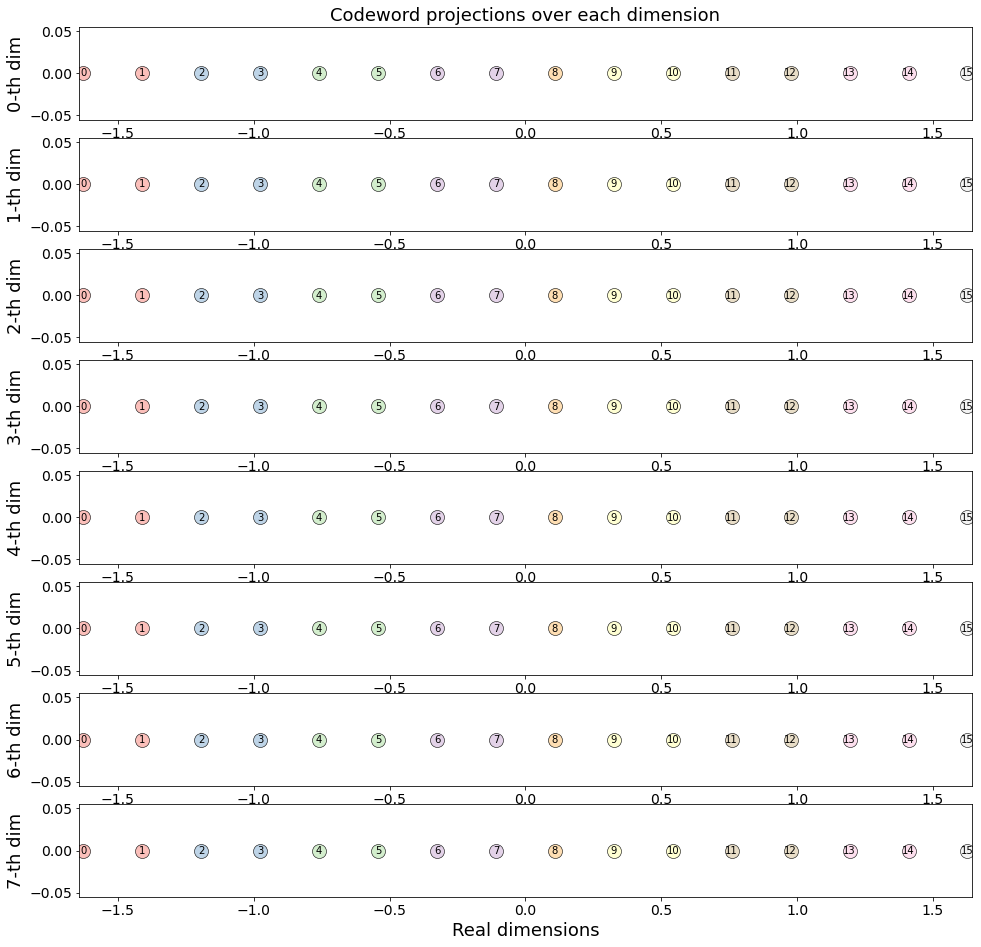

In [20]:
plot_multidimensional_modulation(LDS_Codebook, figsize=(16,16))

The full Monte Carlo simulation framework is available in the following function.

In [21]:
def su_mdm_monte_carlo_loop(EbN0dB, C, P=1):
    '''Monte-Carlo simulation of a single-user multidimensional modulation system.
    
    Inputs:
        EbN0dB: a vector with n simulation points of Eb/N0 (in dB).
        C: a (M x N) matrix where each row is a N-dimensional codeword 
        P: the transmit power as the definition of the SNR = P / noise power
        
    Outputs:
        SER: average symbol error rate for each simulation point
    '''
    
    # ----------------------------------------------------------------------------------------------
    # read inout parameters
    M, N = codebook.shape
    SE   = np.log2(M)
    
    EbN0 = 10**(0.1*EbN0dB)
    SNR  = SE*EbN0
    N0   = P/SNR

    # initialize temporary vectors
    SER                = np.zeros_like(EbN0dB,dtype=np.float64)
    symbol_erros_total = np.zeros_like(EbN0dB,dtype=np.int64)
    iters              = np.zeros_like(EbN0dB,dtype=np.int64)
 
    # helper functions and variables to monitor the simulation status
    start_time = time()
    duration = time() - start_time


    def print_time_status():
        total_duration = time()-start_time
        avg_iter_duration = 1000*total_duration/np.sum(iters)

        print(f' # Total runtime: {total_duration:.4f} s')
        print(f' # Avg iter duration: {avg_iter_duration:.4f}  ms')


    def print_simulation_status():
        print(f' # EbN0: {EbN0dB[idx]:.2f} [dB]')
        print(f' # iter {iters[idx]}/{max_iters} ({100*iters[idx]/max_iters:3.2f}%)')
        print(f' # sym errs: {symbol_erros_total[idx]}/{min_sym_errors} ({100*symbol_erros_total[idx]/min_sym_errors:3.2f}%)')
        print(f' # current SER: {symbol_erros_total[idx]/(iters[idx]*num_packets):1.8f} --> target: {Pe_min:1.8f}')
        
    # ----------------------------------------------------------------------------------------------
    # MAIN LOOP
    
    for idx, noise_samp in enumerate(N0):
        while(symbol_erros_total[idx]<min_sym_errors and iters[idx]<max_iters):
            iters[idx] += 1
            
            # Transmitter
            b = source_bits(k=num_packets*SE)
            s = bin2int_mapping(b, M)
            c = symbol_to_codeword_map(s, C)

            # Receiver
            y, h           = iid_rayleigh_channel(X=c, N0=noise_samp, fading=True, awgn=True)
            faded_codebook = h*C
            s_est          = ML_detection(y, faded_codebook)

            # Error evaluation
            symbol_errors_current    = np.sum(s != s_est)
            symbol_erros_total[idx] += symbol_errors_current

            # Print status
            if ( np.squeeze(iters).sum() % print_iters) == 0:
                clear_output()
                print_simulation_status()
                print_time_status()
                print()
                
        else: # for every point
            SER[idx] = symbol_erros_total[idx]/(iters[idx]*num_packets)
            print(f' # point {idx}, iter {iters[idx]}, SER {SER[idx]}')
            
            if SER[idx] < Pe_min:
                break

    # ----------------------------------------------------------------------------------------------
    # end results
    
    print_simulation_status()
    print_time_status()
    
    return SER

In [22]:
SER_LDS = su_mdm_monte_carlo_loop(EbN0dB=EbN0dB, C=LDS_Codebook, P=Psqrt**2)

 # EbN0: 30.00 [dB]
 # iter 18657/1999999 (0.93%)
 # sym errs: 933/1000 (93.30%)
 # current SER: 0.00100016 --> target: 0.00001000
 # Total runtime: 21.5953 s
 # Avg iter duration: 0.5399  ms

 # point 30, iter 19891, SER 0.0010054798652656982
 # EbN0: 30.00 [dB]
 # iter 19891/1999999 (0.99%)
 # sym errs: 1000/1000 (100.00%)
 # current SER: 0.00100548 --> target: 0.00001000
 # Total runtime: 22.0681 s
 # Avg iter duration: 0.5352  ms


In [23]:
SER_LDS

array([0.77      , 0.75925926, 0.74148148, 0.74296296, 0.72642857,
       0.70068966, 0.65290323, 0.66774194, 0.629375  , 0.59529412,
       0.53894737, 0.51435897, 0.48190476, 0.44622222, 0.39307692,
       0.37407407, 0.3171875 , 0.25367089, 0.22577778, 0.18458716,
       0.13426667, 0.12269939, 0.07333333, 0.05405405, 0.03514938,
       0.02258718, 0.0125    , 0.00820681, 0.00396297, 0.00224891,
       0.00100548])

Finally, we can plot the symbol error-rate performance.

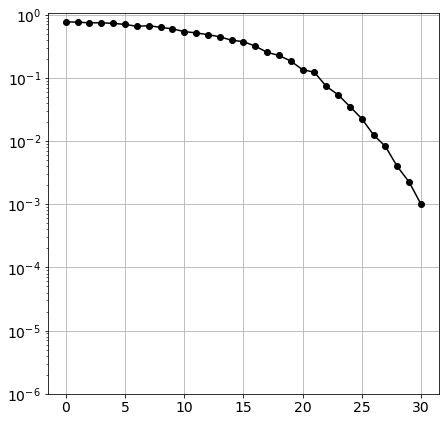

In [24]:
plt.figure(figsize=(7,7))

plt.plot(EbN0dB[SER_LDS>0], SER_LDS[SER_LDS>0],'-ko')
plt.yscale('log')
plt.ylim([1e-6, 1e0+5e-2])
plt.grid()

# ML Autoencoder

In this section, we wish to design the codebook $\mathcal{C} \subseteq \mathbb{R}^{N}$, $\left| \mathcal{C} \right| = M$, using machine learning framework.

### Embedding Layers

Suppose $s\in{\mathbb{Z}_M}$ is a one-hot encoded symbol. <br>
An embedding is a mapping $\lambda:\mathbb{Z}_M\to R^{N}$ (sparse vector, one-hot encoded, to dense real vector).

In [25]:
# check the current design parameters
print((mod_size, n_dims))

(16, 8)


We'll  use the ``Embedding`` layer of Torch. <br>
It converts categorical data with $M$ classes to dense vectors with $N$ dimensions. <br>

In [26]:
# we'll use e() instead of lambda() because the latter is a reserved python word
e = nn.Embedding(num_embeddings=mod_size, 
                 embedding_dim=n_dims)

We can list every possible input of the embedding layer by enumerating the integers $0,\ldots,M-1$.

In [27]:
s = torch.arange(0,mod_size)
s

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

Thus, the codebook can be represented by the "batch" embedding of this list of inputs.  
Note that PyTorch initializes the Embeddings with random values.

In [28]:
E = e(s)
E.shape, E

(torch.Size([16, 8]),
 tensor([[ 1.9269e+00,  1.4873e+00,  9.0072e-01, -2.1055e+00,  6.7842e-01,
          -1.2345e+00, -4.3067e-02, -1.6047e+00],
         [-7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00, -7.2788e-01,
          -5.5943e-01, -7.6884e-01,  7.6245e-01],
         [ 1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01, -7.5813e-01,
           1.0783e+00,  8.0080e-01,  1.6806e+00],
         [ 1.2791e+00,  1.2964e+00,  6.1047e-01,  1.3347e+00, -2.3162e-01,
           4.1759e-02, -2.5158e-01,  8.5986e-01],
         [-1.3847e+00, -8.7124e-01, -2.2337e-01,  1.7174e+00,  3.1888e-01,
          -4.2452e-01,  3.0572e-01, -7.7459e-01],
         [-1.5576e+00,  9.9564e-01, -8.7979e-01, -6.0114e-01, -1.2742e+00,
           2.1228e+00, -1.2347e+00, -4.8791e-01],
         [-9.1382e-01, -6.5814e-01,  7.8024e-02,  5.2581e-01, -4.8799e-01,
           1.1914e+00, -8.1401e-01, -7.3599e-01],
         [-1.4032e+00,  3.6004e-02, -6.3477e-02,  6.7561e-01, -9.7807e-02,
           1.8446e+00, -1.18

### Autoencoder and Loss Function

Different from a supervised learning problem, finding the best embedding falls better under the unsupervised framework, since there are no _correct_ labels to evaluate the output.  
In fact, the input training data is always the same: it is __the set of all possible input symbols that need to be embedded on an output codeword__.  
Thus, we are dealing with an autoencoder, a function that the machine needs to learn in order encode each input symbol into an output codeword.

The autoencoder needs a loss function to evaluate its learning progress.  
There are several approches for the design of single-user multidimensional modulations.  
Thus, any __loss function $\mathcal{L}$__ that can produce __a proper metric over the current embedding $\mathcal{C}$__  can be considered.  This metric will be consider by the optimizer in an iterative manner to adjust the embedding weights.

Below, I propose the use of the minimum squared euclidean distance ($d_{E, \text{min}}^2$) for the loss function.  
It is defined as:  
$d_{E, \text{min}}^2 \left( \mathcal{C} \right) = \min\limits_{\substack{\mathbf{c}_i, \mathbf{c}_j \\ i \neq j}} d_E^2 \left( \mathbf{c}_i, \mathbf{c}_j \right) = \min\limits_{\substack{\mathbf{c}_i, \mathbf{c}_j \\ i \neq j}}  \sum_{n=1}^{N} \left| c_i(n) - c_j(n) \right|^2 $.

Below we write the loss function $d_{E, \text{min}}^2 \left( \mathcal{C} \right)$ as the proper class to be used in PyTorch.  
Note that $d_{E, \text{min}}^2 \left( \mathcal{C} \right)$ is a function that we wish to maximize.  
Thus, to cope with the mimimization of a loss, we define $\mathcal{L}\left(\mathcal{C}\right) = - d_{E, \text{min}}^2 \left( \mathcal{C} \right)$

In [29]:
class AutoEncoderLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, output_embedding): # just a function of the output, it is an unsupervised method
        
        mask_diagonal = torch.diag(torch.ones(mod_size)*np.inf)
        Dist_Matrix = torch.cdist(output_embedding, output_embedding, p=2.0)**2 + mask_diagonal
        min_dist = -Dist_Matrix.min()
        
        return min_dist

### Neural Network Model

Finally, we write the embedding model of neural network.  
Note that, after applying the embedding, __we normalize its average codeword power__.  <br>
This is important so that the proposed codebook does not "_cheat_" the metric by violating the power constraints of the system.

In [30]:
from collections import OrderedDict

class MyModel(nn.Module):
    def __init__(self, mod_size, n_dims):
        super().__init__()
        
        layers_dict = OrderedDict([
              ('embedding', nn.Embedding(num_embeddings=mod_size, # Embedding Layer, the desired output, 
                                         embedding_dim=n_dims)), 
              #('normalization', nn.BatchNorm2d(mod_size)) 
        ])
        self.layers = nn.Sequential(layers_dict) # network object  
    
    def forward(self,x):
        x = self.layers(x)
        x = x[0,:]
        
        Es = torch.sqrt(torch.trace(x@x.T)/x.shape[0])
        
        x = x/Es
        
        return x

Below we set some parameters for the training.  
The maximum number of epochs is the number of times we'll present the full dataset for the network.  
The learning rate influences how much the weights will change proportional to the gradients of the loss function, during the backpropagation step.  

Finally, the optimizer defines which kind of update equation is going to be used.  
Some optimizers have other parameters than just the learning rate.

In [31]:
max_epochs=10000
print_status_iters = 500

learning_rate = 5e-3

Model     = MyModel(mod_size=mod_size, n_dims=n_dims)
criterion = AutoEncoderLoss( )
optimizer = torch.optim.Adam(Model.parameters(), lr=learning_rate)

X_train = torch.arange(0,mod_size).reshape(1,-1)

In [32]:
Model

MyModel(
  (layers): Sequential(
    (embedding): Embedding(16, 8)
  )
)

### Training and Evaluating the Design

Below we can visualize the status of the training.

In [33]:
losses=[]
start_time = time()

for i in range(max_epochs):
    C = Model(X_train)             # forward-prop in network

    loss = criterion(C)                        # loss calculation
    losses.append(loss)                        # save loss
    optimizer.zero_grad()                      # reset gradients
    loss.backward()                            # backprop
    optimizer.step()                           # params update
    
    if i%print_status_iters==1: # print status
        duration = time() - start_time 
        print(f'epoch {i:5.0f} and loss is {loss:5.6f} (runtime: {duration:10.4f} sec)')
        
duration = time() - start_time 
print(f'train took {duration/60} min.')

epoch     1 and loss is -0.474868 (runtime:     0.0080 sec)
epoch   501 and loss is -1.525640 (runtime:     0.6433 sec)
epoch  1001 and loss is -1.664718 (runtime:     1.3893 sec)
epoch  1501 and loss is -1.742771 (runtime:     2.3727 sec)
epoch  2001 and loss is -1.777386 (runtime:     3.2802 sec)
epoch  2501 and loss is -1.800418 (runtime:     4.2197 sec)
epoch  3001 and loss is -1.818356 (runtime:     5.0271 sec)
epoch  3501 and loss is -1.834219 (runtime:     5.8060 sec)
epoch  4001 and loss is -1.843480 (runtime:     6.7675 sec)
epoch  4501 and loss is -1.854266 (runtime:     7.7279 sec)
epoch  5001 and loss is -1.870895 (runtime:     8.6864 sec)
epoch  5501 and loss is -1.901896 (runtime:     9.5855 sec)
epoch  6001 and loss is -1.918353 (runtime:    10.5778 sec)
epoch  6501 and loss is -1.953098 (runtime:    11.5033 sec)
epoch  7001 and loss is -1.976205 (runtime:    12.3271 sec)
epoch  7501 and loss is -1.972625 (runtime:    13.1689 sec)
epoch  8001 and loss is -1.974570 (runti

We can then check if the power normalization worked properly,

In [34]:
torch.trace(C@C.T)/mod_size

tensor(1., grad_fn=<DivBackward0>)

and also visualize the final embedding.

In [35]:
C

tensor([[ 0.5073,  0.5745,  0.1369, -0.3570, -0.4466,  0.2229, -0.1110,  0.0796],
        [ 0.4958, -0.2093, -0.3951,  0.3967,  0.2023,  0.5169, -0.2681,  0.1477],
        [-0.0394,  0.2279,  0.6892,  0.5418,  0.1037, -0.0313, -0.4117,  0.0204],
        [-0.0181, -0.0090, -0.2063,  0.4975, -0.6422, -0.0787,  0.1057, -0.5238],
        [-0.4985,  0.2126,  0.3887, -0.3935, -0.1921, -0.5155,  0.2676, -0.1484],
        [-0.3016, -0.0711,  0.2817,  0.1181, -0.2191,  0.6352,  0.5123,  0.2980],
        [ 0.2955,  0.0784, -0.2775, -0.1201,  0.2209, -0.6364, -0.5219, -0.2923],
        [-0.5078, -0.5810, -0.1443,  0.3530,  0.4460, -0.2208,  0.1130, -0.0700],
        [ 0.2676, -0.6250,  0.2514, -0.0519, -0.4385, -0.3062, -0.1106,  0.4126],
        [-0.2786,  0.6248, -0.2570,  0.0515,  0.4310,  0.2989,  0.1181, -0.4193],
        [-0.1102, -0.4057,  0.2476, -0.3904, -0.0359,  0.4131, -0.3660, -0.5567],
        [ 0.1159,  0.4054, -0.2580,  0.3844,  0.0389, -0.4095,  0.3673,  0.5551],
        [ 0.0238

Finally, let's plot the loss evolution over the epochs.  
For this set of input parameters, it can be seen that the minimum squared euclidean distance converges to value that seems to be maximum one achieved by the network's embedding design 

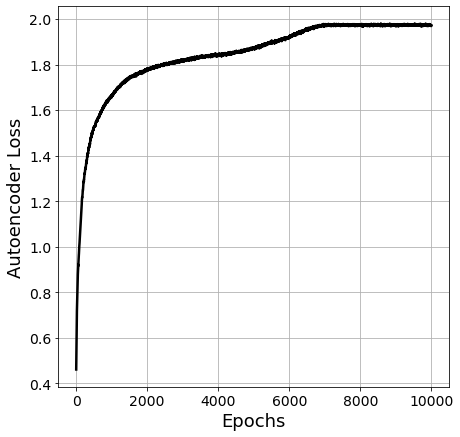

In [36]:
plt.figure(figsize=(7,7))

plt.plot(np.arange(max_epochs),-np.array(losses),'-k',lw=2.5)
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Autoencoder Loss');

We copy the embedding to save the designed codebook, named **"Autoencoder Codebook"**.

In [37]:
#Codebook = Model.layers[0].weight.detach().numpy()
Autoencoder_Codebook = C.detach().numpy().copy()
Autoencoder_Codebook *= Psqrt
Es = np.sqrt(np.trace(Autoencoder_Codebook@Autoencoder_Codebook.T)/Autoencoder_Codebook.shape[0])
Es, Autoencoder_Codebook

(2.8284270404524916,
 array([[ 1.4347736 ,  1.6249694 ,  0.38709432, -1.0098139 , -1.2630976 ,
          0.6304144 , -0.31383935,  0.22517651],
        [ 1.4022242 , -0.5919254 , -1.1174923 ,  1.1219116 ,  0.5721625 ,
          1.4619393 , -0.75836635,  0.41763017],
        [-0.11146724,  0.6446531 ,  1.9493606 ,  1.5325347 ,  0.2934247 ,
         -0.08839788, -1.1645164 ,  0.05783311],
        [-0.05125016, -0.02553201, -0.5834052 ,  1.4071363 , -1.8162944 ,
         -0.22268851,  0.29884887, -1.4816433 ],
        [-1.4100046 ,  0.6011935 ,  1.0994897 , -1.113015  , -0.5433488 ,
         -1.458024  ,  0.7568086 , -0.41969472],
        [-0.8529791 , -0.20098715,  0.796875  ,  0.33412123, -0.61967415,
          1.7965217 ,  1.449074  ,  0.84285665],
        [ 0.835934  ,  0.2217238 , -0.78481317, -0.33982334,  0.62466425,
         -1.7999355 , -1.4761492 , -0.82675207],
        [-1.4362895 , -1.6433173 , -0.40811715,  0.99844974,  1.2613587 ,
         -0.6244236 ,  0.31951922, -0.197951

Now we visualize the projections of the resulting codebook.

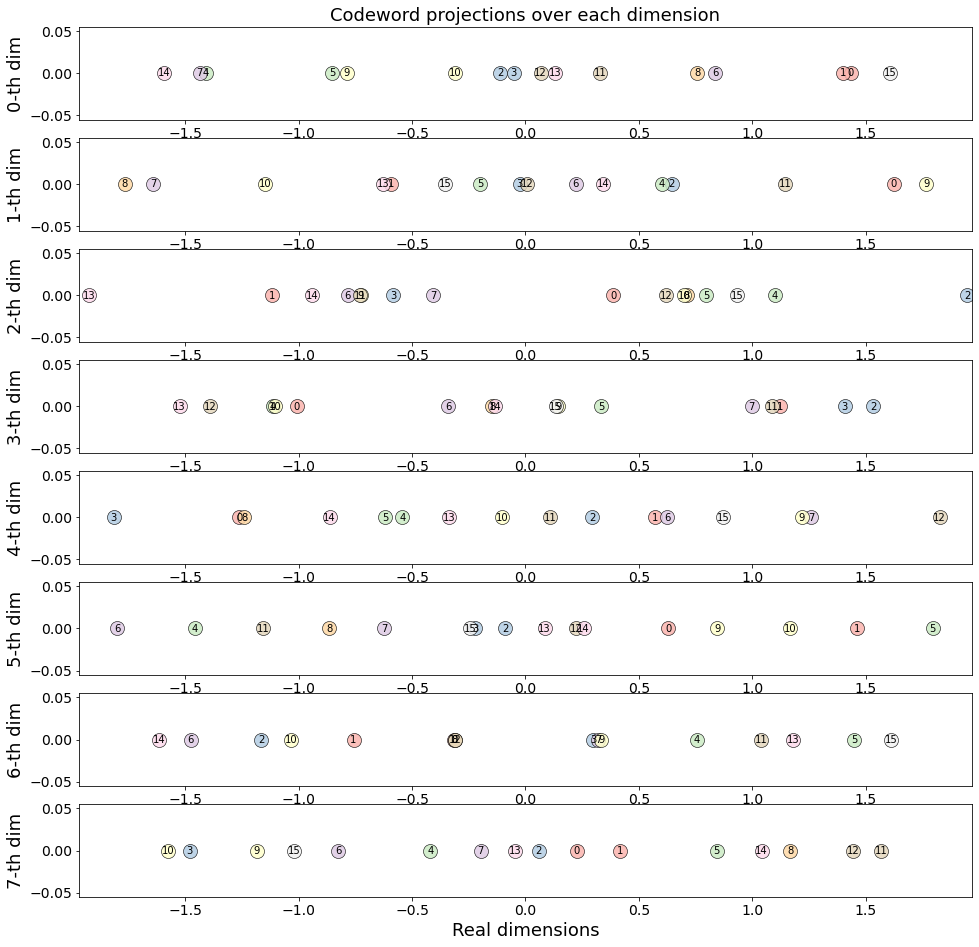

In [38]:
plot_multidimensional_modulation(Autoencoder_Codebook, figsize=(16,16))

## Comparing and Evaluating Codebooks

Also, let's check other figures of merit for the designed Autoencoder Codebook.

In [39]:
get_codebook_figures_of_merit(X=Autoencoder_Codebook, eps=1e-2) 

{'set_cardinality': 16,
 'num_of_dimensions': 8,
 'min_Euclidean_distance_Squared': 15.776961326599121,
 'min_signal_space_diversity': 7,
 'min_Product_distance': 0.00053348887,
 'avg_energy_symbol': 7.999999523162842}

Comparing with the LDS codebook's figures of merit,

In [40]:
get_codebook_figures_of_merit(X=LDS_Codebook, eps=1e-2) 

{'set_cardinality': 16,
 'num_of_dimensions': 8,
 'min_Euclidean_distance_Squared': 0.37647058823529284,
 'min_signal_space_diversity': 8,
 'min_Product_distance': 4.904155841045963e-06,
 'avg_energy_symbol': 8.0}

it becomes clear that the autoencoder optimized the minimum euclidean distance and outperformed the LDS design in this metric.

Just to add another parameter, let's generate a random codebook with the same parameters.  
The projections are taken from Normal Gaussian distribution.

In [41]:
Random_Codebook = np.sqrt(n_dims)*get_codebook(M=mod_size, N=n_dims, LDS=False)
get_codebook_figures_of_merit(Random_Codebook)

{'set_cardinality': 16,
 'num_of_dimensions': 8,
 'min_Euclidean_distance_Squared': 4.360199569423217,
 'min_signal_space_diversity': 7,
 'min_Product_distance': 6.207148592014885e-05,
 'avg_energy_symbol': 8.000000000000002}

Now we run Monte Carlo simulations for the Autoencoder Codebook

In [42]:
SER_Autoencoder = su_mdm_monte_carlo_loop(EbN0dB=EbN0dB, C=Autoencoder_Codebook, P=Psqrt**2)

 # EbN0: 27.00 [dB]
 # iter 1992630/1999999 (99.63%)
 # sym errs: 609/1000 (60.90%)
 # current SER: 0.00000611 --> target: 0.00001000
 # Total runtime: 1928.4899 s
 # Avg iter duration: 0.4043  ms

 # point 27, iter 1999999, SER 6.090003045001522e-06
 # EbN0: 27.00 [dB]
 # iter 1999999/1999999 (100.00%)
 # sym errs: 609/1000 (60.90%)
 # current SER: 0.00000609 --> target: 0.00001000
 # Total runtime: 1931.3134 s
 # Avg iter duration: 0.4043  ms


and for the random codebook

In [43]:
SER_Random = su_mdm_monte_carlo_loop(EbN0dB=EbN0dB, C=Random_Codebook, P=Psqrt**2)

 # EbN0: 30.00 [dB]
 # iter 1994259/1999999 (99.71%)
 # sym errs: 902/1000 (90.20%)
 # current SER: 0.00000905 --> target: 0.00001000
 # Total runtime: 1714.2725 s
 # Avg iter duration: 0.4005  ms

 # point 30, iter 1999999, SER 9.030004515002257e-06
 # EbN0: 30.00 [dB]
 # iter 1999999/1999999 (100.00%)
 # sym errs: 903/1000 (90.30%)
 # current SER: 0.00000903 --> target: 0.00001000
 # Total runtime: 1716.5276 s
 # Avg iter duration: 0.4005  ms


in order to plot all codebook's averge SER in one figure.

Text(0, 0.5, 'SER')

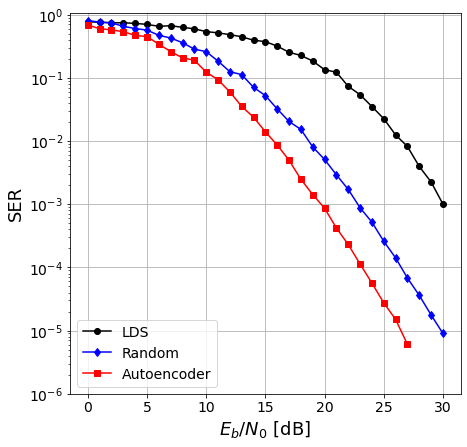

In [44]:
plt.figure(figsize=(7,7))

plt.plot(EbN0dB[SER_LDS>0], SER_LDS[SER_LDS>0],  '-ko',
         EbN0dB[SER_Random>0], SER_Random[SER_Random>0],'-bd',
         EbN0dB[SER_Autoencoder>0], SER_Autoencoder[SER_Autoencoder>0], '-rs')
plt.yscale('log')
plt.ylim([1e-6, 1e0+5e-2])
plt.grid()
plt.legend(['LDS', 'Random', 'Autoencoder'])

plt.xlabel('$E_b/N_0$ [dB]')
plt.ylabel('SER')

Clearly, the Autoencoder shows the better SER performance in Rayleigh fading channels, empirically suggesting that minimizing the proposed loss function is also a way to minimize the SER.